In [22]:
import random
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

# HYPERPARAMETERS
NUM_FEATURES = 16
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
device = 'cuda'

In [23]:
class LinearVAE(nn.Module):
  def __init__(self):
    super(LinearVAE, self).__init__()

    # encoder
    self.encoder = nn.Sequential(
        nn.Linear(in_features=784, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=NUM_FEATURES*2)
    )

    # decoder 
    self.decoder = nn.Sequential(
      nn.Linear(in_features=NUM_FEATURES, out_features=128),
      nn.ReLU(),
      nn.Linear(in_features=128, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=784),
      nn.Sigmoid()
    )

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the encoder's latent space
    :param log_var: log variance from the encoder's latent space
    """
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling as if coming from the input space
    return sample
 
  def forward(self, x):
    # encoding
    x = self.encoder(x)
    x = x.view(-1, 2, NUM_FEATURES)
    # get `mu` and `log_var`
    mu = x[:, 0, :] # the first feature values as mean
    log_var = x[:, 1, :] # the other feature values as variance
    # get the latent vector through reparameterization
    z = self.reparameterize(mu, log_var)

    # decoding
    reconstruction = self.decoder(z)
    return reconstruction, mu, log_var

  def generate(self, sample):
    generated = self.decoder(sample)
    return generated

model = LinearVAE()
print(model)
model = model.to(device)
model.float()

LinearVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


LinearVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [24]:
# transforms
transform = transforms.Compose([
  transforms.ToTensor(),
])
# train and validation data
train_data = datasets.MNIST(
  root='../input/data',
  train=True,
  download=True,
  transform=transform
)
val_data = datasets.MNIST(
  root='../input/data',
  train=False,
  download=True,
  transform=transform
)
# train_data  = torch.utils.data.Subset(train_data, range(0, 10000-1))
# val_data  = torch.utils.data.Subset(val_data, range(0, 2000-1))

# training and validation data loaders
train_loader = torch.utils.data.DataLoader(
  train_data,
  batch_size=BATCH_SIZE,
  shuffle=True
)
val_loader = torch.utils.data.DataLoader(
  val_data,
  batch_size=BATCH_SIZE,
  shuffle=False
)
normal_samples = torch.randn(25, NUM_FEATURES).to(device)

In [25]:
def final_loss(bce_loss, mu, logvar):
  """
  This function will add the reconstruction loss (BCELoss) and the 
  KL-Divergence.
  KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  :param bce_loss: recontruction loss
  :param mu: the mean from the latent vector
  :param logvar: log variance from the latent vector
  """
  BCE = bce_loss 
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE + KLD

In [26]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss(reduction='sum')

def fit(model, dataloader):
  model.train()
  running_loss = 0.0
  for i, data in enumerate(dataloader):
    data, _ = data
    data = data.view(data.size(0), -1).to(device)
    optimizer.zero_grad()
    reconstruction, mu, logvar = model(data)
    bce_loss = criterion(reconstruction, data)
    loss = final_loss(bce_loss, mu, logvar)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss = running_loss/len(dataloader.dataset)
  return train_loss

In [27]:
def validate(model, dataloader, samples):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for i, data in enumerate(dataloader):
      data, _ = data
      data = data.view(data.size(0), -1).to(device)
      reconstruction, mu, logvar = model(data)
      bce_loss = criterion(reconstruction, data)
      loss = final_loss(bce_loss, mu, logvar)
      running_loss += loss.item()

      # save the last batch input and output of every epoch
      if i == int(len(val_data)/dataloader.batch_size) - 1:
        num_rows = 8
        samples.append(torch.cat((data.view(BATCH_SIZE, 1, 28, 28)[:num_rows], 
                           reconstruction.view(BATCH_SIZE, 1, 28, 28)[:num_rows])))

  val_loss = running_loss/len(dataloader.dataset)
  return val_loss

In [28]:
def view_samples(samples, epoch):
  samples = samples.to('cpu')
  fig, axes = plt.subplots(figsize=(5,5), nrows=5, ncols=5, sharex=True, sharey=True)
  for ax, img in zip(axes.flatten(), samples):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
  plt.savefig('graphs/CNN VAE Epoch ' + str(epoch) + '.png')

Epoch [    1/  100] | Train loss: 219.1995 | Val loss: 185.0424
Epoch [    2/  100] | Train loss: 168.8893 | Val loss: 156.4273
Epoch [    3/  100] | Train loss: 150.7628 | Val loss: 143.9764
Epoch [    4/  100] | Train loss: 140.0415 | Val loss: 134.7399
Epoch [    5/  100] | Train loss: 132.9063 | Val loss: 129.2225
Epoch [    6/  100] | Train loss: 128.1523 | Val loss: 125.1469
Epoch [    7/  100] | Train loss: 124.6653 | Val loss: 122.2469
Epoch [    8/  100] | Train loss: 121.9295 | Val loss: 119.5681
Epoch [    9/  100] | Train loss: 119.5996 | Val loss: 117.5128
Epoch [   10/  100] | Train loss: 117.6907 | Val loss: 115.8001
Epoch [   11/  100] | Train loss: 116.0524 | Val loss: 114.3399
Epoch [   12/  100] | Train loss: 114.7038 | Val loss: 112.9607
Epoch [   13/  100] | Train loss: 113.5813 | Val loss: 112.2142
Epoch [   14/  100] | Train loss: 112.6299 | Val loss: 111.4091
Epoch [   15/  100] | Train loss: 111.8459 | Val loss: 110.5105
Epoch [   16/  100] | Train loss: 111.13

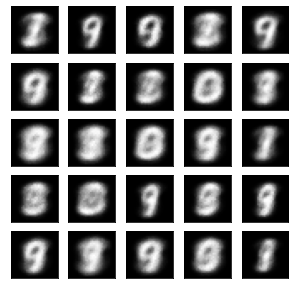

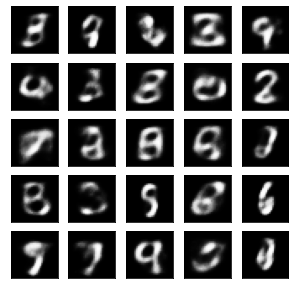

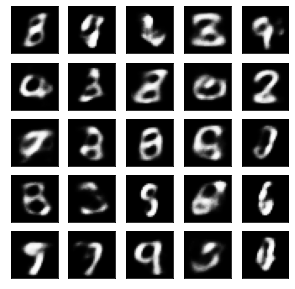

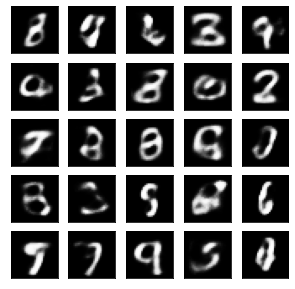

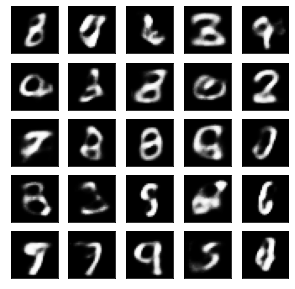

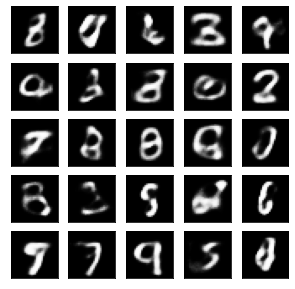

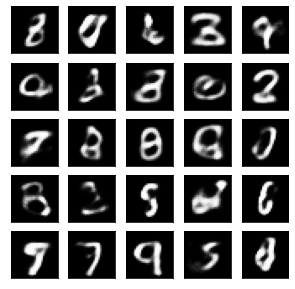

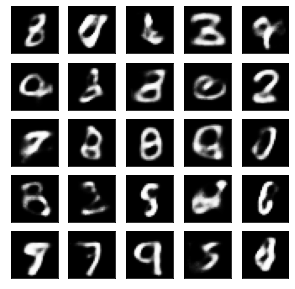

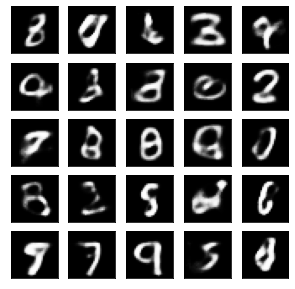

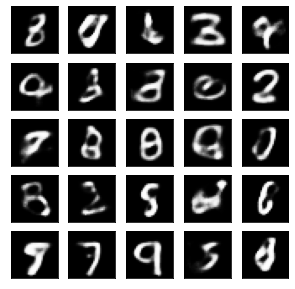

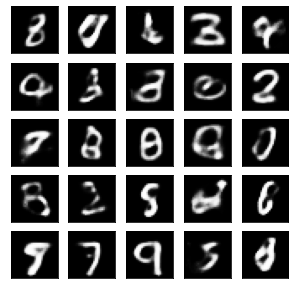

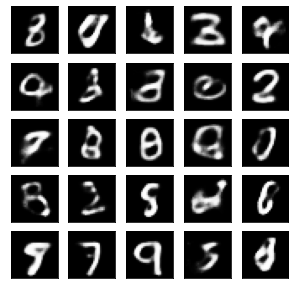

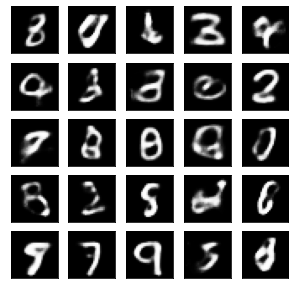

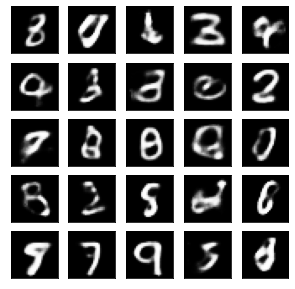

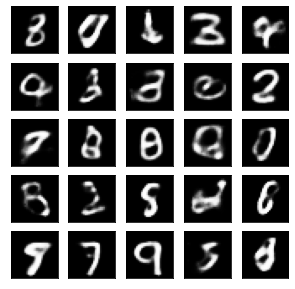

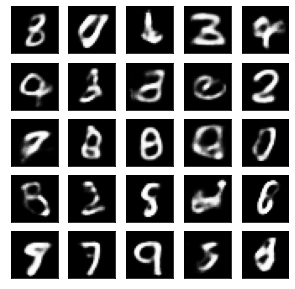

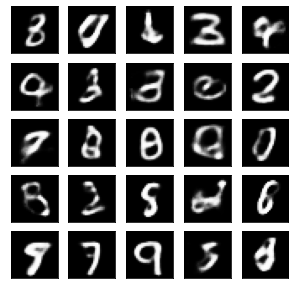

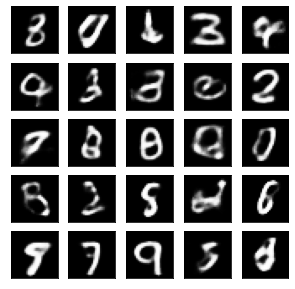

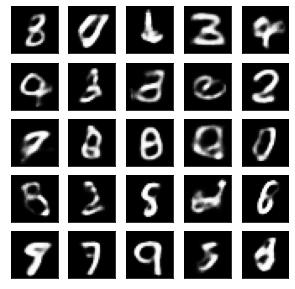

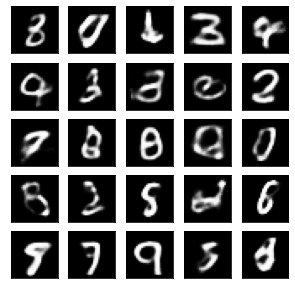

In [29]:
train_loss = []
val_loss = []
samples = []

for epoch in range(NUM_EPOCHS):
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader, samples)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print('Epoch [{:5d}/{:5d}] | Train loss: {:6.4f} | Val loss: {:6.4f}'.format(
                    epoch+1, NUM_EPOCHS, train_epoch_loss, val_epoch_loss))
    if epoch % 5 == 0:
      model.eval()
      generated_images = model.generate(normal_samples)
      generated_images = generated_images.view(25, 1, 28, 28)
      view_samples(generated_images, epoch)

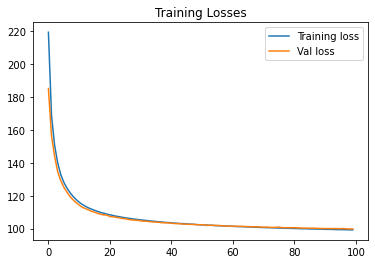

In [30]:
fig, ax = plt.subplots()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Val loss')
plt.title("Training Losses")
plt.legend()

In [31]:
# rows = 5
# fig, axes = plt.subplots(figsize=(7,12), nrows=2*rows, ncols=8, sharex=True, sharey=True)
# flat_axes = [ax for ax_row in axes for ax in ax_row]

# for row in range(rows):
#   sample = samples[row * int(len(samples)/(rows))]
#   view_samples(sample, flat_axes[row*16 : (row+1)*16])

In [32]:
# sample_size = 12
# indices = random.sample(range(0, 2000-1), sample_size)
# sample_subset = torch.utils.data.Subset(val_data, random.sample(range(0, 2000-1), 12))
# loader = torch.utils.data.DataLoader(sample_subset, batch_size=sample_size)
# sample, _ = next(iter(loader))
# print(sample.size())
# sample = sample.view(sample.size(0), -1)
# print(sample.size())

# model.eval()
# reconstruction, _, _ = model(sample)
# print(reconstruction.size())

# out = torch.cat((sample.view(sample_size, 1, 28, 28), 
#            reconstruction.view(sample_size, 1, 28, 28)))

# print(out.size())

# fig, axes = plt.subplots(figsize=(10,2), nrows=2, ncols=sample_size, sharex=True, sharey=True)
# flat_axes = [ax for ax_row in axes for ax in ax_row]

# view_samples(out, flat_axes)

In [33]:
# model.eval()
# normal_samples = torch.randn(sample_size, NUM_FEATURES)
# generated_images = model.generate(normal_samples)
# generated_images = generated_images.view(sample_size, 1, 28, 28)

# fig, axes = plt.subplots(figsize=(10,1), nrows=1, ncols=sample_size, sharex=True, sharey=True)
# flat_axes = [ax for ax in axes]

# view_samples(generated_images, flat_axes)